In [1]:
import cv2
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from u_net_modules import *

from u_net_nn import UNet
import time
from torchsummary import summary
import torchviz
import matplotlib.pyplot as plt

In [2]:
class CustomDataset(Dataset):
    def __init__(self, input_folder,target_folder):
        
        self.folder_path = input_folder
        self.target_path=target_folder

        self.input_file_list = os.listdir(input_folder)
        self.target_file_list=os.listdir(target_folder)



    def __len__(self):
        return len(self.input_file_list)




    def __getitem__(self, idx):
        input_file_name = self.input_file_list[idx]
        # input_file_id=input_file_name.split('_')[-1]
        input_file_id = input_file_name.split('_')[-1].split('.')[0]

        # kojazenie pliku input z targetem
        target_file_name=f'TARGET_{input_file_id}.npy'
        
        target_file_path=os.path.join(self.target_path,target_file_name)

        input_file_path=os.path.join(self.folder_path,input_file_name)

        # wczytywanie
        # file_path = os.path.join(self.folder_path, file_name)
        # data = np.load(file_path)  # Wczytaj dane z pliku .npy

        input_data=np.load(input_file_path)
        target_data=np.load(target_file_path)

        # Sprawdzenie, czy liczba timeseries jest parzysta
        # print("inputshapedata", input_data.shape)
        if input_data.shape[0] % 2 != 0:
            # Usuń ostatnią klatkę czasową, jeśli liczba jest parzysta
            input_data = input_data[:-1, :, :,:]
        # print("inputshapedata after cut", input_data.shape)
        input_tensor=torch.tensor(input_data,dtype=torch.float32)
        # print(target_data.shape)
        target_tensor=torch.tensor(target_data[0,:,:],dtype=torch.float32)
        

        return input_tensor, target_tensor


def collate_fn(batch):
    # Sortujemy batch względem długości sekwencji w tensorze input
    batch = sorted(batch, key=lambda x: x[0].size(2), reverse=True)

    # Rozszerzenie danych docelowych o wymiar channels
    target_data = torch.stack([x[1].unsqueeze(0) for x in batch])

    # Zamiana kolejności kanałów i klatek czasowych w danych wejściowych
    input_data = torch.stack([x[0].permute(1,0,2,3) for x in batch])

    return input_data, target_data




In [3]:
def accuracy(pred,target):

    correct=(pred==target).sum().item()

    total=target.numel()
    accuracy=correct/total

    return accuracy



def test_model(model,data_loader,criterion, device):
    
    model.eval()

    total_accuracy=0.0
    num_samples=0

    with torch.no_grad():
        for batch,target in data_loader:
            
            batch = batch.to(device)
            target = target.to(device)

            output = model(batch)
            loss = criterion(output,target)

            batch_accuracy = accuracy(output,target)

            batch_size=batch.size(0)
            total_accuracy+=batch_accuracy*batch_size
            num_samples+=batch_size
            print("testing")
    
    test_accuracy=total_accuracy/num_samples

    print(f"Test Accuracy: {test_accuracy:.4f}")



In [4]:
# Sprawdzenie dostępności GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available:
    device="cuda"
    print("GPU available")
else:
    device="cpu"
    print("GPU unavailable only CPU")


# Tworzymy instancję klasy Dataset
print("Data loading...")
input_folder = r'F:\pytong\utaeV2\PASTIS_SMOLL\DATA_S2'
target_folder=r'F:\pytong\utaeV2\PASTIS_SMOLL\ANNOTATIONS'
custom_dataset = CustomDataset(input_folder,target_folder)

# Podział na dane testowe i treningowe
dataset_size = len(custom_dataset)
train_size = int(0.8 * dataset_size)  # 80% danych treningowych
test_size = dataset_size - train_size

# Dokonujemy losowego podziału na dane treningowe i testowe
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

# Tworzymy DataLoader z użyciem collate_fn
batch_size = 8
data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
data_loader_test=DataLoader(test_dataset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)

for input_batch, target_batch in data_loader_train:
    # print("Kształt danych wejściowych:", input_batch.shape)
    # print("Kształt danych docelowych:", target_batch.shape)
    break  # Wyświetlamy tylko pierwszy batch

print("Loading successful")


print("Model initialization...")
# Tworzenie modelu sieci U-TAE
in_channels = 10  # Liczba kanałów wejściowych
out_channels = 1  # Liczba kanałów wyjściowych dla problemu klasyfikacji
sequence_length = 61  # Długość szeregu czasowego (ilość zdjęć w sekwencji)
height, width = 128, 128  # Rozmiary wymiarów przestrzennych
# model = UNET_v1(in_channels, out_channels,sequence_length)
model=UNet(in_channels,out_channels)
model.to(device)  # Przenosimy model do GPU
print("Model ready")


GPU available
Data loading...
Loading successful
Model initialization...
Model ready


In [5]:


criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)




num_epochs=3


loss_vector=[]

print("Training...")
for epoch in range(num_epochs):
    # i=0
    start_time=time.time()
    # Teraz możemy iterować przez DataLoader i pobierać dane wsadowo podczas trenowania sieci
    for batch,target in data_loader_train:
        # if i%10==0:
        #     print("batches: ", i)
        # i=i+1
        batch = batch.to(device)
        optimizer.zero_grad()
        output=model(batch)
        
        target=target.to(device)
        loss=criterion(output,target)
        loss.backward()
        optimizer.step()
    end_time=time.time()
    
    elapsed_time=end_time-start_time
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
    print(F'Time per epoch: {elapsed_time:.2f} s')
    loss_vector.append(loss.item())




Training...
x shape: torch.Size([8, 10, 42, 128, 128])
x1 shape: torch.Size([8, 64, 42, 128, 128])
x2 shape: torch.Size([8, 128, 21, 64, 64])
x3 shape: torch.Size([8, 256, 10, 32, 32])
x4 shape: torch.Size([8, 512, 5, 16, 16])
x5 shape: torch.Size([8, 1024, 2, 8, 8])
one more time x shape: torch.Size([8, 10, 42, 128, 128])
x5mean:  torch.Size([8, 1024, 8, 8])
x4mean:  torch.Size([8, 512, 16, 16])
xx1 torch.Size([8, 1024, 8, 8])
xxx1 torch.Size([8, 512, 16, 16])
xxx2 torch.Size([8, 512, 16, 16])
final x shape:  torch.Size([8, 1024, 16, 16])
retshape torch.Size([8, 512, 31, 31])
cat1 x shape: torch.Size([8, 512, 31, 31])
xx1 torch.Size([8, 512, 31, 31])
xxx1 torch.Size([8, 256, 62, 62])
xxx2 torch.Size([8, 256, 32, 32])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 32 but got size 62 for tensor number 1 in the list.

Text(0, 0.5, 'loss')

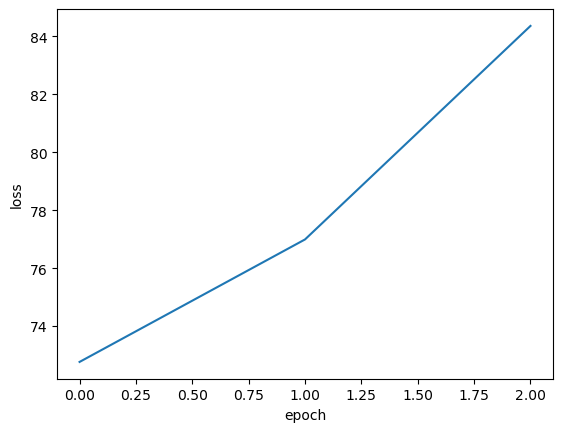

In [ ]:
plt.plot(range(len(loss_vector)),loss_vector)
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
# test_model(model,data_loader_test,criterion,device)

model.eval()

total_accuracy=0.0
num_samples=0

with torch.no_grad():
    for batch,target in data_loader_test:
            
        batch = batch.to(device)
        target = target.to(device)

        output,pred = model(batch)
        loss = criterion(output,target)

        batch_accuracy = accuracy(pred,target)

        batch_size=batch.size(0)
        total_accuracy+=batch_accuracy*batch_size
        num_samples+=batch_size
        print("testing")

  
test_accuracy=total_accuracy/num_samples

print(f"Test Accuracy: {test_accuracy:.4f}")


testing
testing
testing
testing
testing
testing
testing
testing
Test Accuracy: 0.0000


C:\Users\wojtek\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4, 1, 128, 128])) that is different to the input size (torch.Size([4, 1, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


TypeError: Invalid shape (1, 128, 128, 4) for image data

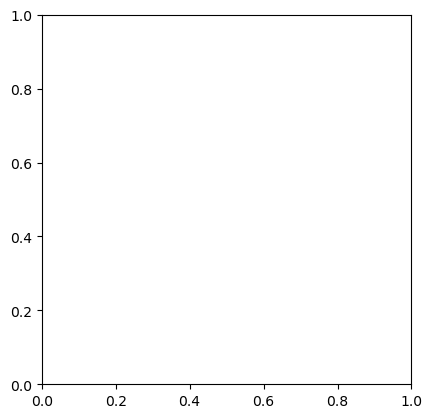

In [ ]:
# Zaimportuj bibliotekę matplotlib
import matplotlib.pyplot as plt

# Przekopiuj tensor na urządzenie CPU i przekształć na numpy array
read_data = output[2, 0, :, :].cpu().numpy()

# Przeskaluj wartości do zakresu od 0 do 255
# scaled_image = (read_data ).astype(np.uint8)

# Utwórz unikalną listę etykiet
unique_labels = np.unique(read_data)

# Wybierz mapę kolorów z matplotlib (np. 'viridis', 'jet', 'coolwarm', 'rainbow', itp.)
cmap_name = 'viridis'

# Wygeneruj mapę kolorów na podstawie etykiet i wybranej mapy kolorów
cmap = plt.get_cmap(cmap_name, len(unique_labels))

# Wygeneruj obraz kolorowy na podstawie etykiet i mapy kolorów
colored_image = cmap(read_data)
plt.imshow(colored_image)
plt.show()


2
0.39958006
0.36963207


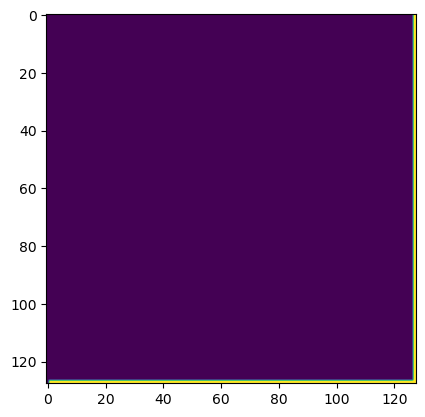

In [ ]:
max_val=np.max(read_data)
min_val=np.min(read_data)

scaled_read=read_data

unique_1=np.unique(scaled_read)
print(len(unique_1))

print(np.max(scaled_read))
print(np.min(scaled_read))

plt.imshow(scaled_read)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


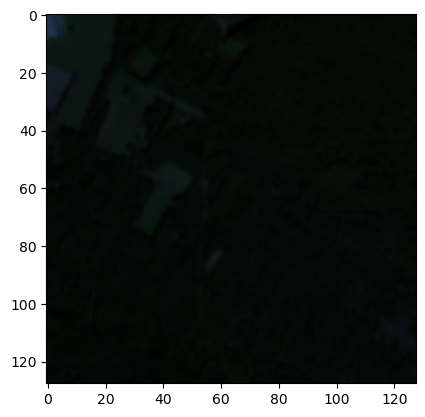

In [ ]:
img_from_batch=batch[2,0:3,1,:,:]
permute_img=img_from_batch.permute(1,2,0)





permute_img=permute_img

scaled_permute=(permute_img/7000)
plt.imshow(scaled_permute.cpu().numpy())
plt.show()





model.eval()
model_path=r'F:\pytong\utaeV2\MODEL\U_NET_V1.pth'
torch.save(model.state_dict(),model_path)